In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('demographic.csv')
df = df.drop('index', axis=1)
df

/tmp/ipykernel_43179/466465776.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('demographic.csv')


,flag_bad,de_age,de_gender,de_date_joined,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_accomodation_type,de_education,...,de_children,ph_total_contacts,ph_other_device_info,ph_call_log_stats,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation
0,0,26,1,08/04/2018 14:50,2535,3000000,1,51,4,2,...,0,66,"{""device_codename"": ""HM2014817"", ""brand"": ""Xia...","{""percent_incoming_nighttime"": 1.83, ""percent_...",id,"['com.google.android.music', 'com.facebook.orc...",male,11/23/1991,2017-12-21T04:38:00+0000,Married
1,0,22,1,02/01/2018 17:17,685,4000000,1,28,4,4,...,0,69,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.google.android.instantapps.supervisor', ...",male,01/20/1995,2017-11-25T17:23:09+0000,NaN
2,1,32,1,01/01/2018 16:39,1765,7000000,1,35,4,4,...,2,315,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 6.65, ""percent_...",id,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",male,10/13/1985,2017-12-23T18:05:57+0000,Married
3,0,31,2,04/01/2018 22:36,407,20000000,3,37,4,3,...,2,84,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",female,07/27/1986,2017-12-05T09:37:19+0000,Married
4,0,27,1,02/01/2018 18:12,3064,3000000,1,36,4,3,...,0,0,"{""device_codename"": ""1609"", ""brand"": ""vivo""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",male,07/05/1990,2017-12-03T09:09:48+0000,In a relationship
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,11/07/2018 22:23,997,5000000,2,51,4,2,...,2,1026,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 5.66, ""percent_...",id,"['com.instagram.android', 'com.google.android....",NaN,NaN,NaN,NaN
41018,0,26,1,11/07/2018 20:28,955,3000000,2,24,4,2,...,0,0,"{""device_codename"": ""nikel"", ""brand"": ""Xiaomi""}","{""percent_incoming_nighttime"": 10.71, ""percent...",id,"['com.youmusic.magictiles', 'com.ayopop', 'com...",NaN,NaN,NaN,NaN
41019,0,22,2,11/07/2018 23:33,881,3000000,1,9,4,4,...,0,272,"{""device_codename"": ""a33g"", ""brand"": ""samsung""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.grabtaxi.passenger', 'jp.co.translimit.b...",female,10/02/1995,2017-10-25T08:05:13+0000,NaN
41020,0,29,2,11/07/2018 22:03,540,6000000,1,51,4,2,...,0,0,"{""device_codename"": ""santoni"", ""brand"": ""Xiaomi""}","{""percent_incoming_nighttime"": 1.27, ""percent_...",id,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com....",NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_date_joined          41022 non-null  object
 4   de_num_friends          41022 non-null  int64 
 5   de_monthly_salary       41022 non-null  int64 
 6   de_employment_type      41022 non-null  int64 
 7   de_employment_duration  41022 non-null  int64 
 8   de_accomodation_type    41022 non-null  int64 
 9   de_education            41022 non-null  int64 
 10  de_marital_status       41022 non-null  int64 
 11  de_children             41022 non-null  int64 
 12  ph_total_contacts       41022 non-null  int64 
 13  ph_other_device_info    41022 non-null  object
 14  ph_call_log_stats       38935 non-null  object
 15  ph

In [4]:
df.isna().sum()/len(df)

flag_bad                  0.000000
de_age                    0.000000
de_gender                 0.000000
de_date_joined            0.000000
de_num_friends            0.000000
de_monthly_salary         0.000000
de_employment_type        0.000000
de_employment_duration    0.000000
de_accomodation_type      0.000000
de_education              0.000000
de_marital_status         0.000000
de_children               0.000000
ph_total_contacts         0.000000
ph_other_device_info      0.000000
ph_call_log_stats         0.050875
ph_country_code           0.000609
ph_app_list               0.000000
fb_gender                 0.036883
fb_dob                    0.235313
fb_last_updated_date      0.035834
fb_relation               0.645044
dtype: float64

Check balanceness of data

In [5]:
df.flag_bad.value_counts()/len(df)

flag_bad
0    0.870313
1    0.129687
Name: count, dtype: float64

Not really unbalanced

In [6]:
df.de_accomodation_type.value_counts()

de_accomodation_type
4    41022
Name: count, dtype: int64

In [7]:
df.ph_country_code.value_counts()

ph_country_code
id    40984
us        3
sg        3
my        2
jp        2
tw        1
kh        1
th        1
Name: count, dtype: int64

Dont use these data, it is not varied enough

# Baseline Modelling

In [8]:
df.de_employment_type.value_counts()

de_employment_type
1    29566
2     6621
3     4833
4        2
Name: count, dtype: int64

In [9]:
df.de_education.value_counts()

de_education
2    24589
4     8258
3     5758
5     1561
1      856
Name: count, dtype: int64

In [10]:
df.de_children.value_counts()

de_children
0    23095
1     8921
2     7249
3     1446
4      311
Name: count, dtype: int64

In [11]:
df.de_marital_status.value_counts()

de_marital_status
1    20154
2    20020
3      500
4      348
Name: count, dtype: int64

In [12]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [13]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  object
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  object
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  object
 8   de_marital_status       41022 non-null  object
 9   de_children             41022 non-null  object
 10  ph_total_contacts       41022 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


In [14]:
df_bs = pd.get_dummies(df_bs)

In [15]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
y_pred = model.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.31      0.02      0.04      1038

    accuracy                           0.87      8205
   macro avg       0.59      0.51      0.49      8205
weighted avg       0.80      0.87      0.82      8205



# Second Model

Employment type 4 assign to 3 because
1. Its not provided in documentation, can be misfill
2. Only 2
3. 3 is the nearest

And we also feature eningeering month of join date

Adding fb gender also and put unstated to nan

Adding joining age feature engineered from join date assume today is the prediction. 

In [20]:
df.fb_relation.value_counts()

fb_relation
Married                                6327
Single                                 4495
In a relationship                      1847
Engaged                                 812
It's complicated                        362
In an open relationship                 158
Married (Pending)                       154
In a domestic partnership               118
Separated                               110
Divorced                                 59
Widowed                                  57
In a relationship (Pending)              28
Engaged (Pending)                        22
In a civil union                          5
In an open relationship (Pending)         3
In a domestic partnership (Pending)       3
It's complicated (Pending)                1
Name: count, dtype: int64

In [21]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    # 'de_date_joined',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
    # 'fb_gender',
    # 'fb_relation'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [22]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [23]:
# df_bs['de_joining_age'] = (pd.Timestamp.today() - pd.to_datetime(df_bs.de_date_joined, dayfirst=True)).dt.days

In [24]:
# df_bs['de_month'] = pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.month
# df_bs = df_bs.drop('de_date_joined', axis=1)

In [25]:
# df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")

In [26]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
# df_bs.de_month = df_bs.de_month.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  object
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  object
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  object
 8   de_marital_status       41022 non-null  object
 9   de_children             41022 non-null  object
 10  ph_total_contacts       41022 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


In [27]:
df_bs = pd.get_dummies(df_bs)

In [28]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [31]:
y_pred = model.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.37      0.03      0.05      1038

    accuracy                           0.87      8205
   macro avg       0.62      0.51      0.49      8205
weighted avg       0.81      0.87      0.82      8205



In this part we try joining age, joining month, fb gender and reducing the employment type number error (4) to 3. Turns out the plain one is better.

# Third Model

In [33]:
df.ph_other_device_info

0        {"device_codename": "HM2014817", "brand": "Xia...
1            {"device_codename": "A1601", "brand": "OPPO"}
2            {"device_codename": "A1601", "brand": "OPPO"}
3            {"device_codename": "A1601", "brand": "OPPO"}
4             {"device_codename": "1609", "brand": "vivo"}
                               ...                        
41017        {"device_codename": "A1601", "brand": "OPPO"}
41018      {"device_codename": "nikel", "brand": "Xiaomi"}
41019      {"device_codename": "a33g", "brand": "samsung"}
41020    {"device_codename": "santoni", "brand": "Xiaomi"}
41021    {"device_codename": "ugglite", "brand": "xiaomi"}
Name: ph_other_device_info, Length: 41022, dtype: object

In [657]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [658]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts,device_codename,brand
0,0,26,1,2535,3000000,1,51,2,2,0,66,HM2014817,Xiaomi
1,0,22,1,685,4000000,1,28,4,1,0,69,A1601,OPPO
2,1,32,1,1765,7000000,1,35,4,2,2,315,A1601,OPPO
3,0,31,2,407,20000000,3,37,3,2,2,84,A1601,OPPO
4,0,27,1,3064,3000000,1,36,3,1,0,0,1609,vivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026,A1601,OPPO
41018,0,26,1,955,3000000,2,24,2,1,0,0,nikel,Xiaomi
41019,0,22,2,881,3000000,1,9,4,1,0,272,a33g,samsung
41020,0,29,2,540,6000000,1,51,2,1,0,0,santoni,Xiaomi


In [659]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  int64 
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  int64 
 8   de_marital_status       41022 non-null  int64 
 9   de_children             41022 non-null  int64 
 10  ph_total_contacts       41022 non-null  int64 
 11  device_codename         41022 non-null  object
 12  brand                   41022 non-null  object
dtypes: int64(11), object(2)
memory usage: 4.1+ MB


In [660]:
df_bs.device_codename.value_counts()

device_codename
mido            1879
santoni         1832
A1601           1628
rolex           1536
A37f            1413
                ... 
EVERCOSS A7B       1
D2212              1
j23g               1
htc_pmeuhl         1
X3                 1
Name: count, Length: 1041, dtype: int64

In [661]:
df_bs.brand.value_counts()

brand
Xiaomi      10008
samsung      8869
OPPO         7474
xiaomi       3756
vivo         2460
            ...  
AF9900          1
Evercoss        1
B6s             1
kyocera         1
O3              1
Name: count, Length: 133, dtype: int64

In [662]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 30 else "others"
)
del counts
df_bs.device_codename_grouped.value_counts()

device_codename_grouped
others       4180
mido         1879
santoni      1832
A1601        1628
rolex        1536
             ... 
X556           31
iPhone6,2      31
HWRNE          31
mlv5           31
alicee         31
Name: count, Length: 195, dtype: int64

In [663]:
counts = df_bs["brand"].value_counts()

df_bs["brand_grouped"] = df_bs["brand"].apply(
    lambda x: x if counts[x] > 25 else "others"
)
del counts
df_bs.brand_grouped.value_counts()

brand_grouped
Xiaomi        10008
samsung        8869
OPPO           7474
xiaomi         3756
vivo           2460
asus           2424
Lenovo         1483
Sony            664
Smartfren       639
lge             515
others          401
Infinix         305
Apple           296
motorola        247
HUAWEI          178
Nokia           139
Meizu           133
ADVAN           119
Coolpad         109
blackberry       82
POLYTRON         81
EVERCOSS         71
acer             63
htc              54
TCL              49
Huawei           47
Hisense          44
INFINIX          42
WIKO             41
google           40
Lava             39
DOCOMO           36
OnePlus          31
ZTE              29
docomo           28
HIMAX            26
Name: count, dtype: int64

In [664]:
df_bs = df_bs.drop(['brand', 'device_codename', 'brand_grouped'], axis=1)

In [665]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [666]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   flag_bad                 41022 non-null  int64 
 1   de_age                   41022 non-null  int64 
 2   de_gender                41022 non-null  object
 3   de_num_friends           41022 non-null  int64 
 4   de_monthly_salary        41022 non-null  int64 
 5   de_employment_type       41022 non-null  object
 6   de_employment_duration   41022 non-null  int64 
 7   de_education             41022 non-null  object
 8   de_marital_status        41022 non-null  object
 9   de_children              41022 non-null  object
 10  ph_total_contacts        41022 non-null  int64 
 11  device_codename_grouped  41022 non-null  object
dtypes: int64(6), object(6)
memory usage: 3.8+ MB


In [667]:
df_bs = pd.get_dummies(df_bs)

In [668]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [669]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [670]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [671]:
y_pred = model.predict(X_test)

In [672]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      7167
           1       0.49      0.03      0.05      1038

    accuracy                           0.87      8205
   macro avg       0.68      0.51      0.49      8205
weighted avg       0.83      0.87      0.82      8205



In this part we see that device codename already represent the brand, and has more rich information than brand only. And after tuning the right number of device codename categorical, we got the number that make the precision highest.

## Mini Experiment

In [616]:
from sklearn.metrics import average_precision_score

In [617]:
average_precision_score(y_test, y_pred)

0.13562720847058443

In [621]:
def mini_exp_device(lim):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts
    
    df_bs = df_bs.drop(['brand', 'device_codename'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [631]:
results = [mini_exp_device(i) for i in range(5,205,5)]

In [633]:
df_res = pd.DataFrame(results)

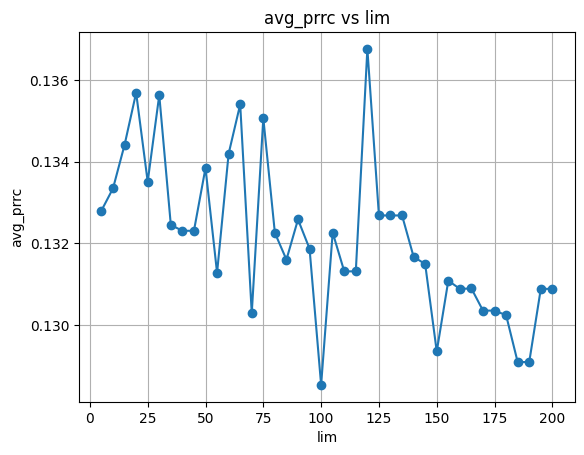

In [673]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

Our choose of 30 before has been good although not the best. Because of the trend that lower lim made it higher, we just take 30 not 120. But we may use in the next experiment.

## Mini Experiment 2

In [677]:
def mini_exp_device(lim):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts
    
    df_bs = df_bs.drop(['brand', 'device_codename'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype("category")
    df_bs.de_employment_type = df_bs.de_employment_type.astype("category")
    df_bs.de_education = df_bs.de_education.astype("category")
    df_bs.de_marital_status = df_bs.de_marital_status.astype("category")
    df_bs.de_children = df_bs.de_children.astype("category")
    
    # df_bs = pd.get_dummies(df_bs)
    df_bs.device_codename_grouped = df_bs.device_codename_grouped.astype("category")
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(enable_categorical=True)
    model.fit(X_train, y_train)
    del X_train, y_train
    
    y_pred = model.predict(X_test)
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_pred)
    }

In [678]:
results = [mini_exp_device(i) for i in range(5,205,5)]

In [679]:
df_res = pd.DataFrame(results)

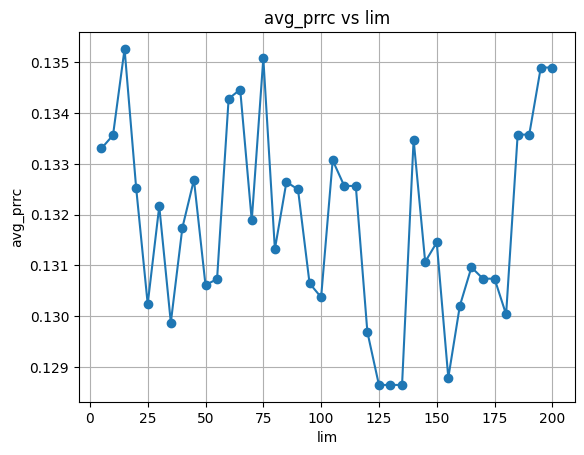

In [680]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# EDA